Copyright 2017, Vladimir Shebunyaev, All rights reserved.

In [2]:
import sys, re, numpy, random, string,json,pyLDAvis,operator
from nltk.corpus import reuters
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/vshebuniayeu/anaconda3/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


In [3]:
iteration=50
samplesize = 200

In [4]:
#случайной выборкой забираем определенное количество тем
idlist = random.sample(reuters.fileids(), samplesize)

In [5]:
labels = []
corpus = []
for id in idlist:
    labels.append(reuters.categories(id))
    corpus.append([x.lower() for x in reuters.words(id) if x[0] in string.ascii_letters])
    reuters.words(id).close()
labelset = list(set(reduce(list.__add__, labels)))

In [6]:
labelset

['reserves',
 'oilseed',
 'dlr',
 'livestock',
 'soybean',
 'dmk',
 'copper',
 'hog',
 'carcass',
 'lead',
 'ship',
 'wheat',
 'coffee',
 'wpi',
 'veg-oil',
 'sugar',
 'zinc',
 'trade',
 'grain',
 'meal-feed',
 'oat',
 'corn',
 'strategic-metal',
 'crude',
 'soy-oil',
 'yen',
 'bop',
 'earn',
 'cpi',
 'soy-meal',
 'rice',
 'acq',
 'money-fx',
 'instal-debt',
 'barley',
 'cotton',
 'gold',
 'nat-gas',
 'interest',
 'lei',
 'ipi',
 'gnp',
 'rubber',
 'money-supply',
 'sorghum',
 'iron-steel']

In [7]:
alpha=0.001
beta=0.001

In [8]:
class LLDA:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    def set_corpus(self, labelset, corpus, labels):
        labelset.insert(0, "common")
        self.labelmap = dict(zip(labelset, range(len(labelset))))        
        self.K = len(self.labelmap)
        self.vocas = []
        self.vocas_id = dict()
        self.labels = numpy.array([self.complement_label(label) for label in labels])

        
        self.docs = [[self.term_to_id(term) for term in doc] for doc in corpus]        
        M = len(corpus)
        V = len(self.vocas)

        self.z_m_n = []
        self.n_m_z = numpy.zeros((M, self.K), dtype=int)
        self.n_z_t = numpy.zeros((self.K, V), dtype=int)
        self.n_z = numpy.zeros(self.K, dtype=int)        
        for m, doc, label in zip(range(M), self.docs, self.labels):
            N_m = len(doc)
            #z_n = [label[x] for x in numpy.random.randint(len(label), size=N_m)]
            z_n = [numpy.random.multinomial(1, label / label.sum()).argmax() for x in range(N_m)]
            self.z_m_n.append(z_n)
            for t, z in zip(doc, z_n):
                self.n_m_z[m, z] += 1
                self.n_z_t[z, t] += 1
                self.n_z[z] += 1        
    def complement_label(self, label):
        if not label: return numpy.ones(len(self.labelmap))
        vec = numpy.zeros(len(self.labelmap))
        vec[0] = 1.0
        for x in label:            
            vec[self.labelmap[x]] = 1.0
        return vec
    def term_to_id(self, term):
        if term not in self.vocas_id:
            voca_id = len(self.vocas)
            self.vocas_id[term] = voca_id
            self.vocas.append(term)
        else:
            voca_id = self.vocas_id[term]
        return voca_id
    def perplexity(self, docs=None):
        if docs == None: docs = self.docs
        phi = self.phi()
        thetas = self.theta()

        log_per = N = 0
        for doc, theta in zip(docs, thetas):
            for w in doc:
                log_per -= numpy.log(numpy.inner(phi[:,w], theta))
            N += len(doc)
        return numpy.exp(log_per / N)
    def phi(self):
        V = len(self.vocas)        
        return (self.n_z_t + self.beta) / (self.n_z[:, numpy.newaxis] + V * self.beta)

    def theta(self):
        """document-topic distribution"""
        n_alpha = self.n_m_z + self.labels * self.alpha
        return n_alpha / n_alpha.sum(axis=1)[:, numpy.newaxis]
    def inference(self):
        V = len(self.vocas)
        for m, doc, label in zip(range(len(self.docs)), self.docs, self.labels):
            for n in range(len(doc)):
                t = doc[n]
                z = self.z_m_n[m][n]
                self.n_m_z[m, z] -= 1
                self.n_z_t[z, t] -= 1
                self.n_z[z] -= 1

                denom_a = self.n_m_z[m].sum() + self.K * self.alpha
                denom_b = self.n_z_t.sum(axis=1) + V * self.beta
                p_z = label * (self.n_z_t[:, t] + self.beta) / denom_b * (self.n_m_z[m] + self.alpha) / denom_a
                new_z = numpy.random.multinomial(1, p_z / p_z.sum()).argmax()

                self.z_m_n[m][n] = new_z
                self.n_m_z[m, new_z] += 1
                self.n_z_t[new_z, t] += 1
                self.n_z[new_z] += 1

In [9]:
llda = LLDA(alpha, beta)

In [10]:
llda.set_corpus(labelset, corpus, labels)

In [11]:
labelmap = dict(zip(labelset, range(len(labelset))))            
K = len(labelmap)
print("M=%d, V=%d, L=%d, K=%d" % (len(corpus), len(llda.vocas), len(labelset), K))

M=200, V=3374, L=47, K=47


In [12]:
x = []
y = []
for i in range(iteration):
    perplexity = llda.perplexity()
    sys.stderr.write("-- %d : %.4f\n" % (i, perplexity))
    x.append(i)
    y.append(perplexity)
    llda.inference()
print("perplexity : %.4f" % llda.perplexity())

-- 0 : 315.4675
-- 1 : 277.6375
-- 2 : 270.1713
-- 3 : 268.4347
-- 4 : 268.3338
-- 5 : 268.4251
-- 6 : 269.1209
-- 7 : 268.1581
-- 8 : 267.8215
-- 9 : 267.8167
-- 10 : 268.0330
-- 11 : 267.8705
-- 12 : 268.3264
-- 13 : 268.1841
-- 14 : 268.0235
-- 15 : 267.9605
-- 16 : 268.2163
-- 17 : 268.1616
-- 18 : 267.9449
-- 19 : 268.7069
-- 20 : 268.2265
-- 21 : 267.7345
-- 22 : 268.6963
-- 23 : 268.5349
-- 24 : 269.0239
-- 25 : 267.6535
-- 26 : 267.7998
-- 27 : 267.6927
-- 28 : 268.4426
-- 29 : 267.6834
-- 30 : 266.7446
-- 31 : 266.4816
-- 32 : 266.4753
-- 33 : 266.9163
-- 34 : 266.8036
-- 35 : 267.5551
-- 36 : 267.2843
-- 37 : 267.3641
-- 38 : 267.0343
-- 39 : 267.2302
-- 40 : 267.2132
-- 41 : 267.5950
-- 42 : 267.4667
-- 43 : 267.5330
-- 44 : 266.0848
-- 45 : 265.6338
-- 46 : 265.2195
-- 47 : 265.7284
-- 48 : 266.2815
-- 49 : 265.8344


perplexity : 265.5519


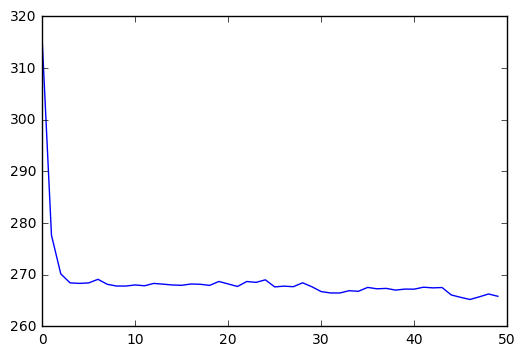

In [13]:

plt.plot(x, y)

In [14]:
phi = llda.phi()
result = {}
for k, label in enumerate(labelset):
    #print("\n-- label %d : %s" % (k, label))
    result[label]=[]
    for w in numpy.argsort(-phi[k])[:10]:
        #print("%s: %.4f" % (llda.vocas[w], phi[k,w]))
        result[label].append(str(llda.vocas[w])+":"+str(phi[k,w]))

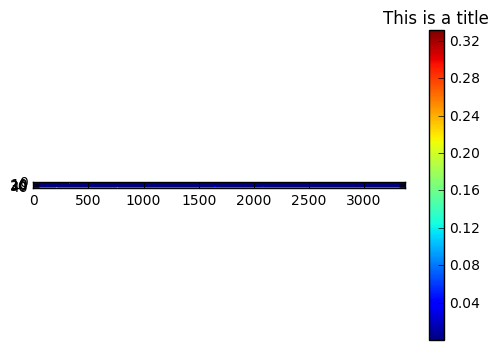

In [15]:
import numpy as np
import matplotlib.pylab as plt 

#dat = np.random.randn(10,10)
dat = phi
#dat = np.array(dat)
#dat = np.minimum(100, dat*100)
#dat = dat.astype(np.int32)


plt.imshow(dat, interpolation='none')

clb = plt.colorbar()
clb.ax.set_title('This is a title')

#plt.show()

In [16]:
dat

array([[  2.65378559e-04,   8.84300431e-08,   1.06124895e-03, ...,
          8.84300431e-08,   8.84300431e-08,   8.84300431e-08],
       [  1.22889375e-05,   1.22889375e-05,   1.22889375e-05, ...,
          1.22889375e-05,   1.22889375e-05,   1.22889375e-05],
       [  1.87357140e-05,   1.87357140e-05,   1.87357140e-05, ...,
          1.87357140e-05,   1.87357140e-05,   1.87357140e-05],
       ..., 
       [  2.30552866e-05,   2.30552866e-05,   2.30552866e-05, ...,
          2.30552866e-05,   2.30552866e-05,   2.30552866e-05],
       [  1.05961388e-05,   1.05961388e-05,   1.05961388e-05, ...,
          1.05961388e-05,   1.05961388e-05,   1.05961388e-05],
       [  2.82693504e-05,   2.82693504e-05,   2.82693504e-05, ...,
          2.82693504e-05,   2.82693504e-05,   2.82693504e-05]])

In [17]:
pandaResult = pd.DataFrame(result).T

In [18]:
pandaResult

,0,1,2,3,4,5,6,7,8,9
acq,of:0.0348957953319,lt:0.0296086337234,said:0.0222066074716,shares:0.0206204589891,inc:0.0190343105065,company:0.017448162024,is:0.0158620135415,it:0.0153332973806,stock:0.0148045812198,group:0.0148045812198
barley,not:0.248359172668,average:0.177404477241,planted:0.106449781814,does:0.106449781814,equal:0.0709724341008,free:0.0709724341008,sept:0.0532337602441,projections:0.0354950863873,projection:0.0177564125306,rough:0.0177564125306
bop,dlrs:0.140170442998,billion:0.115641228703,pct:0.0630786266443,mln:0.0525661062325,or:0.0385494123501,deficit:0.0350452388795,imports:0.0315410654089,rose:0.0315410654089,quarter:0.0245327184677,fell:0.0210285449971
carcass,expected:0.0622216139548,australian:0.0622216139548,pork:0.0622216139548,forecast:0.0622216139548,and:0.0497797795307,than:0.0497797795307,checkoff:0.0497797795307,refunds:0.0373379451066,less:0.0373379451066,output:0.0373379451066
coffee,producers:0.0606642673245,coffee:0.0606642673245,meeting:0.0471848167469,ico:0.0404450914581,delegates:0.0269656408805,market:0.0269656408805,export:0.0269656408805,producer:0.0269656408805,dauster:0.0269656408805,consumers:0.0269656408805
common,the:0.0886069915976,of:0.0455415606169,to:0.0450109803584,in:0.032542344284,a:0.0300663030777,said:0.0297125829054,and:0.0280324120868,s:0.0181282472617,for:0.0137951751507,on:0.010876983729
copper,copper:0.140404229438,price:0.0936184148966,magma:0.0936184148966,newmont:0.0468326003556,cent:0.0468326003556,lb:0.0468326003556,cathode:0.0468326003556,lowering:0.0468326003556,cts:0.0468326003556,subsidiary:0.0468326003556
corn,corn:0.202320962225,for:0.110365248097,other:0.0919741052709,marketing:0.0919741052709,october:0.0735829624453,meal:0.0551918196197,long:0.0551918196197,feedgrains:0.0551918196197,seed:0.0368006767941,include:0.0368006767941
cotton,the:0.103124409232,bales:0.0859384398577,cotton:0.0773454551704,and:0.0515665011085,u:0.0515665011085,in:0.0515665011085,s:0.0429735164212,crop:0.0429735164212,weather:0.0343805317339,bureau:0.0343805317339
cpi,canada:0.171173098314,price:0.0856079404467,february:0.0856079404467,pct:0.0856079404467,statistics:0.0856079404467,index:0.0856079404467,consumer:0.0856079404467,in:0.0856079404467,rose:0.0856079404467,met:4.27825789339e-05


In [20]:
doc_lengths = []
for e in llda.docs:
    doc_lengths.append(len(e))


In [21]:
tf = {}
for doc in llda.docs:
    for w in doc:
        if w in tf:
            tf[w]+=1
        else:
            tf[w]=1
            
tf2 = {}
for e in llda.vocas_id:
    tf2[e]=tf[llda.vocas_id[e]]
    
data = {'topic_term_dists': llda.phi(),
        'doc_topic_dists': llda.theta(),
        'vocab':llda.vocas,
        'doc_lengths':doc_lengths,
        'term_frequency':tf2
       }

#term_frequency

In [22]:
movies_model_data = data

In [23]:
print('Topic-Term shape: %s' % str(np.array(movies_model_data['topic_term_dists']).shape))
print('Doc-Topic shape: %s' % str(np.array(movies_model_data['doc_topic_dists']).shape))

Topic-Term shape: (47, 3374)
Doc-Topic shape: (200, 47)


In [24]:
movies_vis_data = pyLDAvis.prepare(**movies_model_data)

In [25]:
pyLDAvis.display(movies_vis_data)

In [26]:
sorted_x = sorted(llda.labelmap.items(), key=operator.itemgetter(1))
pd.Series(sorted_x)

0               (common, 0)
1             (reserves, 1)
2              (oilseed, 2)
3                  (dlr, 3)
4            (livestock, 4)
5              (soybean, 5)
6                  (dmk, 6)
7               (copper, 7)
8                  (hog, 8)
9              (carcass, 9)
10               (lead, 10)
11               (ship, 11)
12              (wheat, 12)
13             (coffee, 13)
14                (wpi, 14)
15            (veg-oil, 15)
16              (sugar, 16)
17               (zinc, 17)
18              (trade, 18)
19              (grain, 19)
20          (meal-feed, 20)
21                (oat, 21)
22               (corn, 22)
23    (strategic-metal, 23)
24              (crude, 24)
25            (soy-oil, 25)
26                (yen, 26)
27                (bop, 27)
28               (earn, 28)
29                (cpi, 29)
30           (soy-meal, 30)
31               (rice, 31)
32                (acq, 32)
33           (money-fx, 33)
34        (instal-debt, 34)
35             (barl

In [27]:
sorted_x = sorted(llda.labelmap.items(), key=operator.itemgetter(1))

In [28]:
sorted_x

[('common', 0),
 ('reserves', 1),
 ('oilseed', 2),
 ('dlr', 3),
 ('livestock', 4),
 ('soybean', 5),
 ('dmk', 6),
 ('copper', 7),
 ('hog', 8),
 ('carcass', 9),
 ('lead', 10),
 ('ship', 11),
 ('wheat', 12),
 ('coffee', 13),
 ('wpi', 14),
 ('veg-oil', 15),
 ('sugar', 16),
 ('zinc', 17),
 ('trade', 18),
 ('grain', 19),
 ('meal-feed', 20),
 ('oat', 21),
 ('corn', 22),
 ('strategic-metal', 23),
 ('crude', 24),
 ('soy-oil', 25),
 ('yen', 26),
 ('bop', 27),
 ('earn', 28),
 ('cpi', 29),
 ('soy-meal', 30),
 ('rice', 31),
 ('acq', 32),
 ('money-fx', 33),
 ('instal-debt', 34),
 ('barley', 35),
 ('cotton', 36),
 ('gold', 37),
 ('nat-gas', 38),
 ('interest', 39),
 ('lei', 40),
 ('ipi', 41),
 ('gnp', 42),
 ('rubber', 43),
 ('money-supply', 44),
 ('sorghum', 45),
 ('iron-steel', 46)]

In [29]:
llda.K

47

In [30]:
len(corpus)

200

In [ ]:
set_corpus(self, labelset, corpus, labels):
        labelset.insert(0, "common")
        self.labelmap = dict(zip(labelset, range(len(labelset))))        
        self.K = len(self.labelmap)
        self.vocas = []
        self.vocas_id = dict()
        

        
        self.docs = [[self.term_to_id(term) for term in doc] for doc in corpus]
        print(self.docs)
        M = len(corpus)
        V = len(self.vocas)

        self.z_m_n = []
        self.n_m_z = numpy.zeros((M, self.K), dtype=int)
        self.n_z_t = numpy.zeros((self.K, V), dtype=int)
        self.n_z = numpy.zeros(self.K, dtype=int)
        print(self.n_m_z)
        print(self.n_z_t)
        print(self.n_z)
        for m, doc, label in zip(range(M), self.docs, self.labels):
            N_m = len(doc)
            #z_n = [label[x] for x in numpy.random.randint(len(label), size=N_m)]
            z_n = [numpy.random.multinomial(1, label / label.sum()).argmax() for x in range(N_m)]
            self.z_m_n.append(z_n)
            for t, z in zip(doc, z_n):
                self.n_m_z[m, z] += 1
                self.n_z_t[z, t] += 1
                self.n_z[z] += 1        
    def perplexity(self, docs=None):
        if docs == None: docs = self.docs
        phi = self.phi()
        thetas = self.theta()

        log_per = N = 0
        for doc, theta in zip(docs, thetas):
            for w in doc:
                log_per -= numpy.log(numpy.inner(phi[:,w], theta))
            N += len(doc)
        return numpy.exp(log_per / N)
    def phi(self):
        
        return (self.n_z_t + self.beta) / (self.n_z[:, numpy.newaxis] + V * self.beta)

    def inference(self):
        
        for m, doc, label in zip(range(len(self.docs)), self.docs, self.labels):
            for n in range(len(doc)):
                t = doc[n]
                z = self.z_m_n[m][n]
                self.n_m_z[m, z] -= 1
                self.n_z_t[z, t] -= 1
                self.n_z[z] -= 1

                denom_a = self.n_m_z[m].sum() + self.K * self.alpha
                denom_b = self.n_z_t.sum(axis=1) + V * self.beta
                p_z = label * (self.n_z_t[:, t] + self.beta) / denom_b * (self.n_m_z[m] + self.alpha) / denom_a
                new_z = numpy.random.multinomial(1, p_z / p_z.sum()).argmax()

                
                

In [31]:
for k,v in (llda.vocas_id).items():
    if v == 67:
        print(k)    

exercisable


In [32]:
len(llda.vocas_id)

3374

In [33]:
len(llda.docs)

200

In [34]:
tf

{0: 4,
 1: 1,
 2: 54,
 3: 138,
 4: 1,
 5: 62,
 6: 3,
 7: 11,
 8: 131,
 9: 88,
 10: 165,
 11: 288,
 12: 44,
 13: 16,
 14: 350,
 15: 17,
 16: 4,
 17: 2,
 18: 6,
 19: 609,
 20: 14,
 21: 12,
 22: 2,
 23: 4,
 24: 2,
 25: 2,
 26: 221,
 27: 1,
 28: 1,
 29: 2,
 30: 4,
 31: 22,
 32: 81,
 33: 380,
 34: 108,
 35: 29,
 36: 72,
 37: 2,
 38: 372,
 39: 1,
 40: 531,
 41: 2,
 42: 10,
 43: 424,
 44: 1033,
 45: 1,
 46: 12,
 47: 9,
 48: 4,
 49: 91,
 50: 17,
 51: 4,
 52: 100,
 53: 4,
 54: 26,
 55: 6,
 56: 40,
 57: 4,
 58: 187,
 59: 12,
 60: 54,
 61: 20,
 62: 43,
 63: 8,
 64: 134,
 65: 38,
 66: 47,
 67: 1,
 68: 2,
 69: 15,
 70: 35,
 71: 1,
 72: 64,
 73: 39,
 74: 3,
 75: 179,
 76: 23,
 77: 2,
 78: 1,
 79: 17,
 80: 37,
 81: 1,
 82: 5,
 83: 18,
 84: 2,
 85: 2,
 86: 250,
 87: 3,
 88: 2,
 89: 4,
 90: 11,
 91: 3,
 92: 1,
 93: 19,
 94: 4,
 95: 17,
 96: 1,
 97: 44,
 98: 149,
 99: 2,
 100: 9,
 101: 1,
 102: 1,
 103: 24,
 104: 9,
 105: 10,
 106: 2,
 107: 16,
 108: 71,
 109: 7,
 110: 123,
 111: 66,
 112: 1,
 113: 42,


In [35]:
llda.vocas_id

{'dairy': 2006,
 'foreign': 971,
 'costs': 644,
 'accepted': 1001,
 'annouce': 1351,
 'fargo': 1562,
 'distribute': 1841,
 'local': 1537,
 'complexity': 3256,
 'being': 257,
 'party': 1254,
 'made': 389,
 'initial': 703,
 'avgprice': 1778,
 'losses': 647,
 'for': 58,
 'mcalpine': 3314,
 'path': 2249,
 'daewoo': 1054,
 'contributions': 2444,
 'borrowings': 973,
 'application': 476,
 'crushings': 1785,
 'wages': 1325,
 'highest': 956,
 'tnl': 2066,
 'restated': 2456,
 'vice': 877,
 'esmah': 2008,
 'owns': 1362,
 'diversified': 2851,
 'decrease': 2962,
 'mahn': 2888,
 'deter': 2450,
 'gy': 1341,
 'stem': 646,
 'shortages': 2366,
 'sumitomo': 2505,
 'h': 1131,
 'assumption': 2106,
 'undermine': 2550,
 'probably': 241,
 'merrill': 1903,
 'board': 35,
 'tied': 1651,
 'min': 3359,
 'free': 1420,
 'review': 2488,
 'ton': 1800,
 'and': 149,
 'modify': 2462,
 'weeks': 1973,
 'nation': 2370,
 'tass': 2232,
 'ruled': 2349,
 'directors': 1169,
 'terms': 246,
 'unnecessary': 604,
 'distribution': 55

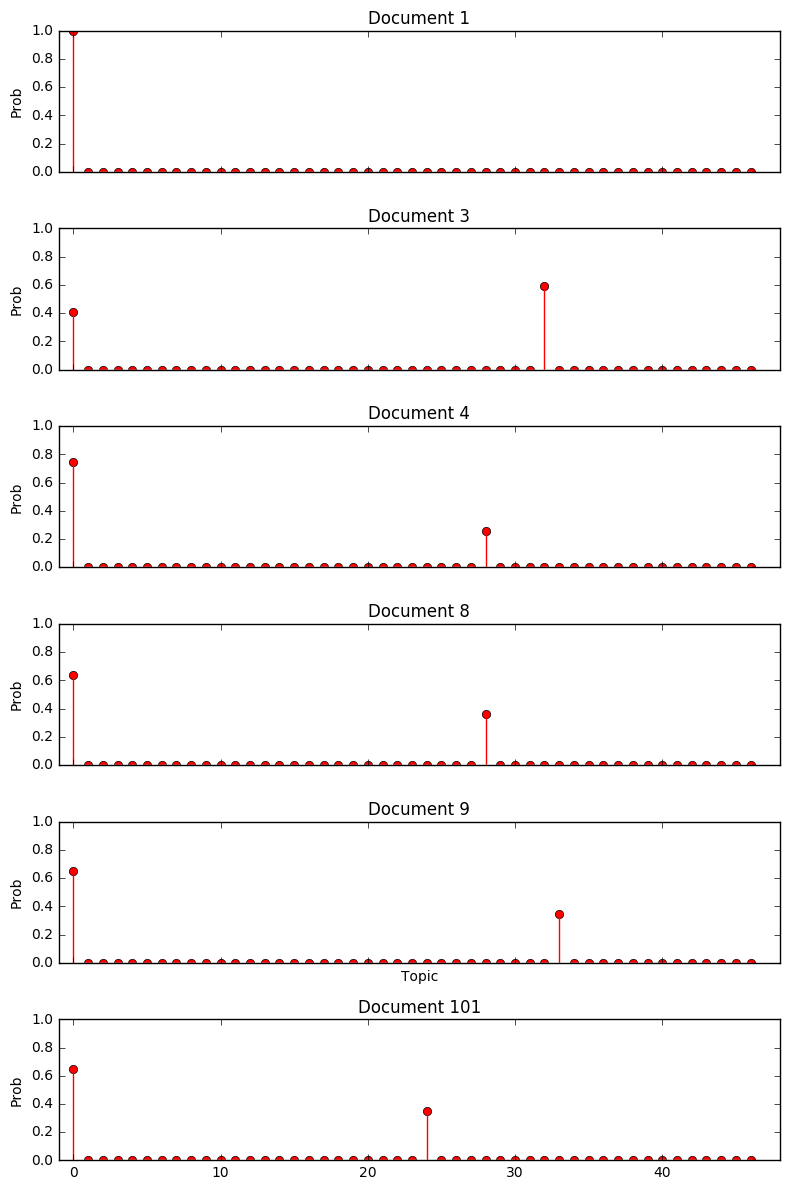

In [36]:
f, ax= plt.subplots(6, 1, figsize=(8, 12), sharex=True)
K = len(labelmap)
for i, k in enumerate([1, 3, 4, 8, 9,101]):
    #ax[i].stem(doc_topic[k,:], linefmt='r-',
    ax[i].stem(llda.theta()[k], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-1, K+1)
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("Document {}".format(k))    
    
ax[4].set_xlabel("Topic")
plt.tight_layout()
#текст документа
#название тематики

In [37]:
print(corpus[101])
#print(llda.theta()[100])
print(llda.theta()[101][29])
print(sorted_x[29])
print(sorted_x[13])

['tass', 'denounces', 'u', 's', 'attack', 'on', 'iran', 'as', 'adventurism', 'the', 'official', 'soviet', 'news', 'agency', 'tass', 'denounced', 'a', 'u', 's', 'attack', 'on', 'an', 'iranian', 'oil', 'drilling', 'platform', 'in', 'the', 'gulf', 'on', 'monday', 'as', 'military', 'adventurism', 'and', 'said', 'it', 'would', 'bring', 'no', 'dividends', 'to', 'the', 'reagan', 'administration', 'tass', 'commentator', 'mikhail', 'krutikhin', 'said', 'the', 'administration', 'had', 'embarked', 'on', 'an', 'adventurist', 'path', 'in', 'order', 'to', 'deflect', 'attention', 'from', 'the', 'scandal', 'in', 'which', 'the', 'united', 'states', 'sold', 'arms', 'to', 'iran', 'and', 'the', 'profits', 'were', 'diverted', 'to', 'nicaraguan', 'rebels', 'the', 'confrontation', 'is', 'a', 'fact', 'now', 'what', 'is', 'obvious', 'is', 'that', 'the', 'latest', 'military', 'adventure', 'will', 'not', 'bring', 'political', 'dividends', 'to', 'the', 'american', 'administration', 'krutikhin', 'said', 'soviet', 

In [38]:
#print(corpus[100])
print(corpus[9])
#print(llda.theta()[100])
print(llda.theta()[9][:13])
print(sorted_x[12])
print(sorted_x[13])

['u', 'k', 'money', 'market', 'gets', 'mln', 'stg', 'late', 'help', 'the', 'bank', 'of', 'england', 'said', 'it', 'provided', 'about', 'mln', 'stg', 'in', 'late', 'help', 'to', 'the', 'money', 'market', 'bringing', 'the', 'total', 'assistance', 'today', 'to', 'mln', 'stg', 'this', 'compares', 'with', 'the', 'bank', 's', 'revised', 'estimate', 'of', 'a', 'mln', 'stg', 'money', 'market', 'shortfall']
[ 0.65305498  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
('wheat', 12)
('coffee', 13)


In [39]:
print(llda.theta()[101,32])
print(llda.theta()[101,0])

0.0
0.648400471229


In [40]:
r = (llda.theta())

In [41]:
r[9]

array([ 0.65305498,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.34694502,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [42]:
#self.labelmap = dict(zip(labelset, range(len(labelset))))        

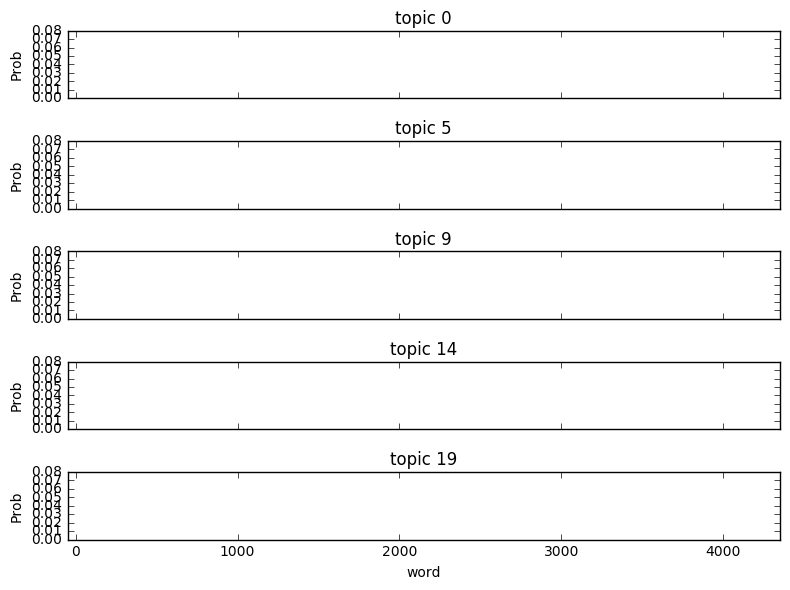

In [43]:
f, ax= plt.subplots(5, 1, figsize=(8, 6), sharex=True)
for i, k in enumerate([0, 5, 9, 14, 19]):
    #ax[i].stem(topic_word[k,:], linefmt='b-',
    #           markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(-50,4350)
    ax[i].set_ylim(0, 0.08)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k))

ax[4].set_xlabel("word")

plt.tight_layout()
plt.show()